In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [28]:
df = pd.read_csv('diabetic_data.csv', na_values='?')

df.head()

/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Identyfikacja kolumn

Zmienną objaśnianą jest `readmitted` - ilość dni, która upłyneła do ponownego przyjęcia do szpitala.\
Klasy nie są zbalansowane, więc prawdopodobnie użyta będzie inna metryka niż accuracy.

In [4]:
df.readmitted.value_counts()

Pierwsze dwie kolumny czyli `encounter_id` i `patient_nbr` są identyfikatorami, więc nie są zmiennymi objaśniającymi.

In [29]:
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

#### Braki danych 

In [6]:
na_count = df.isnull().sum(axis = 0) / df.shape[0]
na_count[na_count > 0]

W zmiennej `weight`, `payer_code` oraz `medical_speciality` brakuje zbyt dużo obserwacji, zatem imputacja nie ma tutaj sensu i lepiej usunąć te zmienne. 

In [30]:
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

W zmiennych `race`, `diag_1`, `diag_2` oraz `diag_3` nie brakuje dużo obserwacji, zatem usuwając brakujące wiersze nie stracimy dużo informacji.

In [8]:
df.shape[0]

101766

In [9]:
df = df[ df['race'].notna() ]
df = df[ df['diag_1'].notna() ]
df = df[ df['diag_2'].notna() ]
df = df[ df['diag_3'].notna() ]

In [10]:
df.shape[0]

98053

In [11]:
na_count = df.isnull().sum(axis = 0) / df.shape[0]
na_count[na_count > 0].shape[0]

0

#### Korelacje

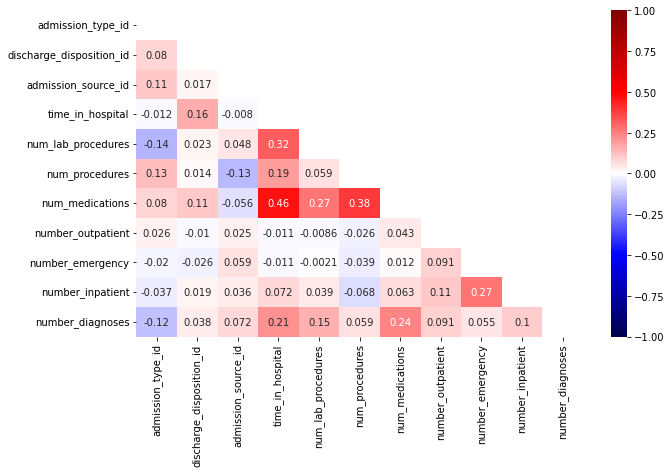

In [21]:
c = df.corr()
mask = np.triu(np.ones_like(c, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(c, mask=mask, annot=True, vmin=-1, vmax=1, cmap="seismic")
plt.show()

#### Encoding zmiennych

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98053 entries, 1 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      98053 non-null  object
 1   gender                    98053 non-null  object
 2   age                       98053 non-null  object
 3   admission_type_id         98053 non-null  int64 
 4   discharge_disposition_id  98053 non-null  int64 
 5   admission_source_id       98053 non-null  int64 
 6   time_in_hospital          98053 non-null  int64 
 7   num_lab_procedures        98053 non-null  int64 
 8   num_procedures            98053 non-null  int64 
 9   num_medications           98053 non-null  int64 
 10  number_outpatient         98053 non-null  int64 
 11  number_emergency          98053 non-null  int64 
 12  number_inpatient          98053 non-null  int64 
 13  diag_1                    98053 non-null  object
 14  diag_2               

In [23]:
one_hot_features = ['race', 'gender', 'admission_type_id', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
                    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
                    'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                    'metformin-pioglitazone', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']

binary_features = ['change', 'diabetesMed']
ordinal_feautures = ['age']

In [31]:
age_levels = [['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']]


transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), one_hot_features),
    (OrdinalEncoder(categories=age_levels), ['age']),
    (OneHotEncoder(sparse=False), binary_features),
)

df = pd.DataFrame(transformer.fit_transform(df))